# 1 - Downloading Data, and doing a Quality Assessment

**Objectives:**
1. Install software
2. Donwload dataset
3. Run a clear-sky pvanalytics routine (or other)

## 1. Setup

In [1]:
# if running on google colab, uncomment the next line and execute this cell to install the dependencies and prevent "ModuleNotFoundError" in later cells:
# Dev branch example: !pip install git+https://github.com/NREL/PV_ICE.git@development
!pip install -r https://raw.githubusercontent.com/NREL/pvdaq_access/main/requirements.txt
!pip install pvanalytics

In [1]:
import pvanalytics
pvanalytics.__version__
from pvanalytics.features.clearsky import reno       #update to just do a pvanalytics import?
import pvlib
import matplotlib.pyplot as plt
import pandas as pd
import pathlib  # this might not be needed as working on same directory as data here?
import os
import glob
import pathlib
from pvanalytics.quality import data_shifts as ds
from pvanalytics.quality import gaps
from pvanalytics.quality.outliers import zscore
from pvanalytics.features.daytime import power_or_irradiance
from pvanalytics.quality.time import shifts_ruptures
from pvanalytics.features import daytime
from pvanalytics.system import (is_tracking_envelope,
                                infer_orientation_fit_pvwatts)
from pvanalytics.features.clipping import geometric

In [3]:
# This information helps with debugging and getting support :)
import sys, platform
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("PVlib version ", pvlib.__version__)
print("pvanalytics version ", pvanalytics.__version__)
print("pvdaq_access version ", None)

Working on a  Windows 10
Python version  3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
Pandas version  2.0.3
PVlib version  0.10.3
pvanalytics version  0.2.0a2.dev9+gd169f5d
pvdaq_access version  None


In [4]:
testfolder = 'Tuesday'

if not os.path.exists(testfolder):
    os.makedirs(testfolder)

## 2. Download

pvdaq Script :( 

In [2]:
import os
import boto3
import botocore
import argparse
from botocore.handlers import disable_signing
import pandas as pd

#---------------------------------------------------------------------------   
def downloadSolarPrizeData(system_id, path, file_type='csv'):
    '''
    Method to access and pull Solar Data Bounty Prize datasets from 
    the OEDI Data Lake for PVDAQ
    Parameters:
    -----------------------
    system_id : str - system id value found from query of Solar Data Prize systems 
    available .
    path : str - local system location files are to be stored in.
    file_type : str - default is .csv, but parquet canbe passed in as option
    
    Returns
    -----------------------
    void
    
    '''
    s3 = boto3.resource("s3")
    s3.meta.client.meta.events.register("choose-signer.s3.*", disable_signing)
    bucket = s3.Bucket("oedi-data-lake")
    
    #Find each target file in buckets
    target_dir = system_id + '_OEDI'
    prefix =  "pvdaq/2023-solar-data-prize/" +  target_dir + "/data/"
    objects = bucket.objects.filter(Prefix=prefix)
    
    for obj in objects:
        if obj.key == prefix:
            continue            
        try:
            bucket.download_file(obj.key, os.path.join(path, os.path.basename(obj.key)).replace("\\", "/"))
        except botocore.exceptions.ClientError as e:
            print ('ERROR: Boto3 exception ' + str(e))
        else:
            print ('File ' + os.path.join(path, os.path.basename(obj.key)) + " downloaded successfully.")
            
    return


#---------------------------------------------------------------------------   
def downloadData(system_id, path, file_type='csv'):
    '''
    Method to access and pull data from the OEDI Data Lake for PVDAQ
    Parameters:
    -----------------------
    system_id : str - system id value found from query of OEDI PVDAQ queue 
    of available .
    path : str - local system location files are to be stored in.
    file_type : str - default is .csv, but parquet canbe passed in as option
    
    Returns
    -----------------------
    void
    
    '''
    s3 = boto3.resource("s3")
    s3.meta.client.meta.events.register("choose-signer.s3.*", disable_signing)
    bucket = s3.Bucket("oedi-data-lake")
    
    #Find each target file in buckets
    objects = bucket.objects.filter(
        Prefix="pvdaq/" + file_type + "/pvdata/system_id=" + system_id )
    
    for obj in objects:
        try:
            bucket.download_file(obj.key, os.path.join(path, os.path.basename(obj.key)))
        except botocore.exceptions.ClientError as e:
            print ('ERROR: Boto3 exception ' + str(e))
        else:
            print ('File ' + os.path.join(path, os.path.basename(obj.key)) + " downloaded successfully.")
            
    return


#---------------------------------------------------------------------------   
def concatenateData(system_id, path):
    '''
    Method to merge the multiple files coming in from OEDI
    Parameters:
    -----------------------
    system_id : str - system id value found from query of OEDI PVDAQ queue 
    of available .
    path : str - local system location files are to be stored in.
    
    Returns
    -----------------------
    void
    
    '''
    dfs = []
    #get list of files in directory
    file_list= glob.glob(os.path.join(path, "*" + system_id + "*"))
    column_name = 'sensor_name'
    #Build a dataframe from current file
    print ("Starting data extraction")
    for file in file_list:
        print("Extracting file " + file)
        df_file= pd.read_csv(file, index_col = 0, parse_dates = True)
        dfs.append(df_file)
         
    #Build the master data frame from the assembled individual frames.
    print ("Concatenating all files")
    df = pd.concat(dfs, axis = 1)
    target_outputfile = path + "/system_" + system_id + "_data.csv"
    print ("File is " + target_outputfile)
    df.to_csv(target_outputfile, sep=",")
    return

Actually running now

In [6]:
print (" ..: Starting data access script for PVDAQ OEDI datasets :..")

#Get parameters from command line
parser = argparse.ArgumentParser()
parser.add_argument('-system', type=str,  help="Target system ID")
parser.add_argument('-path', type=str,  help="Location to store files locally")
parser.add_argument('-parquet', help="Access parquet files (default is .csv)", action="store_true")
args, unknown = parser.parse_known_args()

if args.system:
    input_string = input("Are you accessing data from the DOE Solar Data Bounty Prize: (Y/N): ")
    #Handle Solar Data Bounty Prize archives
    if input_string.lower() == 'y':
        downloadSolarPrizeData(args.system, args.path, file_type='csv')
        quit()

    else:   #Normal PVDAQ archives
        if args.parquet:
            downloadData(args.system, args.path, file_type='parquet')
        else:
            downloadData(args.system, args.path)
            #Create single file from data
            input_string = input("Do you wish to concatenate the files (Y/N): ") 
            if input_string.lower() == 'y':
                concatenateData(args.system, args.path)
else:
    print('Missing system_id, Exiting.')

 ..: Starting data access script for PVDAQ OEDI datasets :..
Missing system_id, Exiting.


# 3. Look at the data

The NREL PV Fleets Data Initiative uses PVAnalytics routines to assess the quality of systems’ PV data. In the following examples, the PV Fleets process for assessing the data quality of a temperature, irradiance, and power data stream are shown. These example pipelines illustrates how several PVAnalytics functions can be used in sequence to assess the quality of a temperature, irradiance, or power data stream.

First, we import the temperature, irradiance, and power data stream from a PV installation under the [2023 solar data prize data set](https://data.openei.org/s3_viewer?bucket=oedi-data-lake&limit=100&prefix=pvdaq%2F2023-solar-data-prize%2F). This data set is publicly available via the PVDAQ database in the DOE Open Energy Data Initiative (OEDI) (https://data.openei.org/submissions/4568), under system ID 2105. This data is timezone-localized.

In [7]:
# Download Solar Prize Data
downloadSolarPrizeData("2105", "./Data/")

File ./Data/2105_environment_1_data.csv downloaded successfully.
File ./Data/2105_environment_2_data.csv downloaded successfully.
File ./Data/2105_inv01_data.csv downloaded successfully.
File ./Data/2105_inv02_data.csv downloaded successfully.
File ./Data/2105_inv03_data.csv downloaded successfully.
File ./Data/2105_inv04_data.csv downloaded successfully.
File ./Data/2105_inv05_data.csv downloaded successfully.
File ./Data/2105_inv06_data.csv downloaded successfully.
File ./Data/2105_inv07_data.csv downloaded successfully.
File ./Data/2105_inv08_data.csv downloaded successfully.
File ./Data/2105_inv09_data.csv downloaded successfully.
File ./Data/2105_inv10_data.csv downloaded successfully.
File ./Data/2105_inv11_data.csv downloaded successfully.
File ./Data/2105_irradiance_data.csv downloaded successfully.
File ./Data/2105_meter_data.csv downloaded successfully.


In [8]:
# Concatenate files together
concatenateData("2105", "./Data/")

Starting data extraction
Extracting file ./Data\2105_environment_1_data.csv
Extracting file ./Data\2105_environment_2_data.csv
Extracting file ./Data\2105_inv01_data.csv
Extracting file ./Data\2105_inv02_data.csv
Extracting file ./Data\2105_inv03_data.csv
Extracting file ./Data\2105_inv04_data.csv
Extracting file ./Data\2105_inv05_data.csv
Extracting file ./Data\2105_inv06_data.csv
Extracting file ./Data\2105_inv07_data.csv
Extracting file ./Data\2105_inv08_data.csv
Extracting file ./Data\2105_inv09_data.csv
Extracting file ./Data\2105_inv10_data.csv
Extracting file ./Data\2105_inv11_data.csv
Extracting file ./Data\2105_irradiance_data.csv
Extracting file ./Data\2105_meter_data.csv
Concatenating all files
File is ./Data//system_2105_data.csv


In [3]:
# Read time series and set latitude and longitude
main_time_series = pd.read_csv("./Data/system_2105_data.csv", index_col=0, parse_dates=True)
main_time_series = main_time_series.resample("15T").mean()
main_time_series = main_time_series.tz_localize("Etc/GMT-10")
# Site latitude and longitude
latitude = 20.884134
longitude = -156.340543

## 3.1: Fleets QA Process -Temperature

PV Fleets Temperature QA Pipeline

The NREL PV Fleets Data Initiative uses PVAnalytics routines to assess the quality of systems’ PV data. In this example, the PV Fleets process for assessing the data quality of a temperature data stream is shown. This example pipeline illustrates how several PVAnalytics functions can be used in sequence to assess the quality of a temperature data stream.

First, we import an ambient temperature data stream from a PV installation under the [2023 solar data prize data set](https://data.openei.org/s3_viewer?bucket=oedi-data-lake&limit=100&prefix=pvdaq%2F2023-solar-data-prize%2F). This data set is publicly available via the PVDAQ database in the DOE Open Energy Data Initiative (OEDI) (https://data.openei.org/submissions/4568), under system ID 2105. This data is timezone-localized.

In [4]:
# Get temperature column and turn it into a series
temp_time_series = main_time_series["ambient_temp_(c)_o_150228"].dropna()
# Identify the temperature data stream type (this affects the type of
# checks we do)
data_stream_type = "ambient"

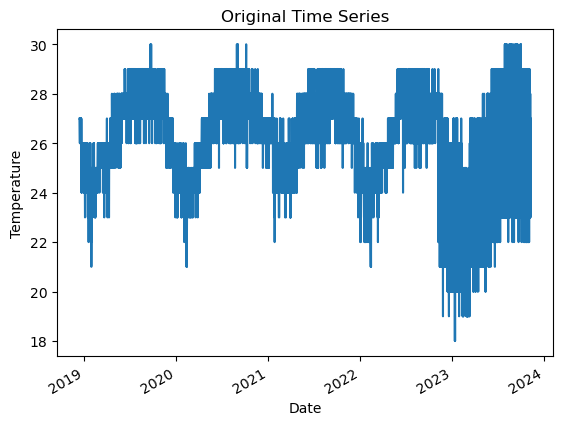

In [5]:
temp_time_series.plot(title="Original Time Series")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.show()

Now, let’s run basic data checks to identify stale and abnormal/outlier data in the time series. Basic data checks include the following steps:

1. Flatlined/stale data periods [(pvanalytics.quality.gaps.stale_values_round()).](https://pvanalytics--202.org.readthedocs.build/en/202/generated/pvanalytics.quality.gaps.stale_values_round.html#pvanalytics.quality.gaps.stale_values_round)

2. “Abnormal” data periods, which are out of the temperature limits of -40 to 185 deg C. Additional checks based on thresholds are applied depending on the type of temperature sensor (ambient or module) [(pvanalytics.quality.weather.temperature_limits()).](https://pvanalytics--202.org.readthedocs.build/en/202/generated/pvanalytics.quality.weather.temperature_limits.html#pvanalytics.quality.weather.temperature_limits)

3. Outliers, which are defined as more than one 4 standard deviations away from the mean [(pvanalytics.quality.outliers.zscore()).](https://pvanalytics--202.org.readthedocs.build/en/202/generated/pvanalytics.quality.outliers.zscore.html#pvanalytics.quality.outliers.zscore)

Additionally, we identify the units of the temperature stream as either Celsius or Fahrenheit.

Estimated Temperature units: C


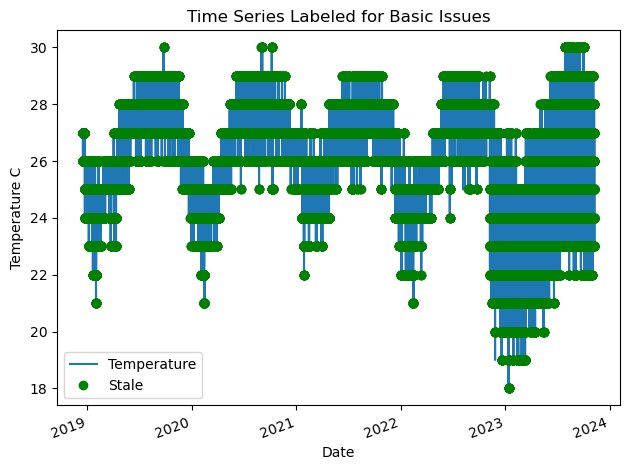

In [6]:
# REMOVE STALE DATA
stale_data_mask = gaps.stale_values_round(temp_time_series,
                                          window=3,
                                          decimals=2)

# FIND ABNORMAL PERIODS
temperature_limit_mask = pvanalytics.quality.weather.temperature_limits(
    temp_time_series, limits=(-40, 185))
temperature_limit_mask = temperature_limit_mask.reindex(
    index=temp_time_series.index,
    method='ffill',
    fill_value=False)

# FIND OUTLIERS (Z-SCORE FILTER)
zscore_outlier_mask = zscore(temp_time_series,
                             zmax=4,
                             nan_policy='omit')

# PERFORM ADDITIONAL CHECKS, INCLUDING CHECKING UNITS (CELSIUS OR FAHRENHEIT)
temperature_mean = temp_time_series.mean()
if temperature_mean > 35:
    temp_units = 'F'
else:
    temp_units = 'C'

print("Estimated Temperature units: " + str(temp_units))

# Run additional checks based on temperature sensor type.
if data_stream_type == 'module':
    if temp_units == 'C':
        module_limit_mask = (temp_time_series <= 85)
        temperature_limit_mask = (temperature_limit_mask & module_limit_mask)
if data_stream_type == 'ambient':
    ambient_limit_mask = pvanalytics.quality.weather.temperature_limits(
        temp_time_series, limits=(-40, 120))
    temperature_limit_mask = (temperature_limit_mask & ambient_limit_mask)
    if temp_units == 'C':
        ambient_limit_mask_2 = (temp_time_series <= 50)
        temperature_limit_mask = (temperature_limit_mask &
                                  ambient_limit_mask_2)
# Get the percentage of data flagged for each issue, so it can later be logged
pct_stale = round((len(temp_time_series[
    stale_data_mask].dropna())/len(temp_time_series.dropna())*100), 1)
pct_erroneous = round((len(temp_time_series[
    ~temperature_limit_mask].dropna())/len(temp_time_series.dropna())*100), 1)
pct_outlier = round((len(temp_time_series[
    zscore_outlier_mask].dropna())/len(temp_time_series.dropna())*100), 1)

# Visualize all of the time series issues (stale, abnormal, outlier)
temp_time_series.plot()
labels = ["Temperature"]
if any(stale_data_mask):
    temp_time_series.loc[stale_data_mask].plot(ls='',
                                          marker='o',
                                          color="green")
    labels.append("Stale")
if any(~temperature_limit_mask):
    temp_time_series.loc[~temperature_limit_mask].plot(ls='',
                                                  marker='o',
                                                  color="yellow")
    labels.append("Abnormal")
if any(zscore_outlier_mask):
    temp_time_series.loc[zscore_outlier_mask].plot(ls='',
                                              marker='o',
                                              color="purple")
    labels.append("Outlier")
plt.legend(labels=labels)
plt.title("Time Series Labeled for Basic Issues")
plt.xticks(rotation=20)
plt.xlabel("Date")
plt.ylabel(f"Temperature {temp_units}")
plt.tight_layout()
plt.show()

Now, let’s filter out any of the flagged data from the basic temperature checks (stale or abnormal data). Then we can re-visualize the data post-filtering.

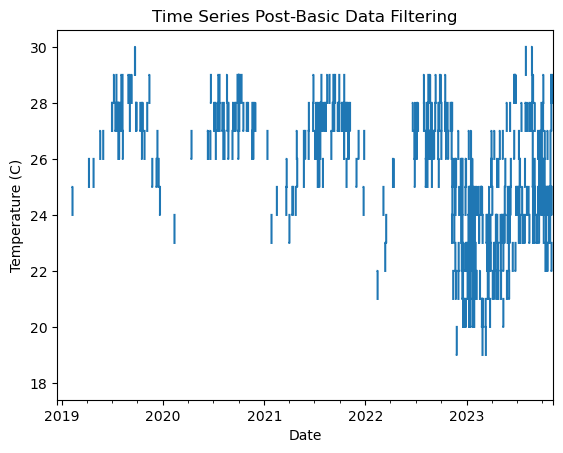

In [7]:
# Filter the time series, taking out all of the issues
issue_mask = ((~stale_data_mask) & (temperature_limit_mask) &
              (~zscore_outlier_mask))
temp_time_series = temp_time_series[issue_mask]
data_freq = "15T"
temp_time_series = temp_time_series.asfreq(data_freq)

# Visualize the time series post-filtering
temp_time_series.plot(title="Time Series Post-Basic Data Filtering")
plt.xlabel("Date")
plt.ylabel("Temperature (C)")
plt.show()


We filter the time series based on its daily completeness score. This filtering scheme requires at least 25% of data to be present for each day to be included. We further require at least 10 consecutive days meeting this 25% threshold to be included.

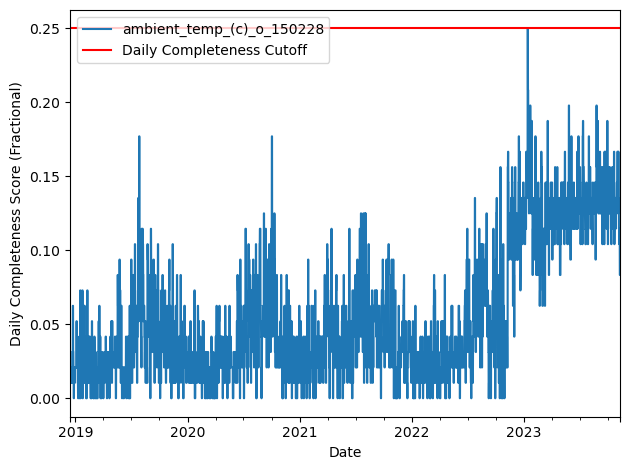

In [8]:
# Visualize daily data completeness
data_completeness_score = gaps.completeness_score(temp_time_series)

# Visualize data completeness score as a time series.
data_completeness_score.plot()
plt.xlabel("Date")
plt.ylabel("Daily Completeness Score (Fractional)")
plt.axhline(y=0.25, color='r', linestyle='-',
            label='Daily Completeness Cutoff')
plt.legend()
plt.tight_layout()
plt.show()

# Trim the series based on daily completeness score
trim_series = pvanalytics.quality.gaps.trim_incomplete(
    temp_time_series,
    minimum_completeness=.25,
    freq=data_freq)
first_valid_date, last_valid_date = \
    pvanalytics.quality.gaps.start_stop_dates(trim_series)
if first_valid_date is not None:
    temp_time_series = temp_time_series[first_valid_date.tz_convert(temp_time_series.index.tz):
                              last_valid_date.tz_convert(temp_time_series.index.tz)]
    temp_time_series = temp_time_series.asfreq(data_freq)

Next, we check the time series for any abrupt data shifts. We take the longest continuous part of the time series that is free of data shifts. We use [pvanalytics.quality.data_shifts.detect_data_shifts()](https://pvanalytics--202.org.readthedocs.build/en/202/generated/pvanalytics.quality.data_shifts.detect_data_shifts.html#pvanalytics.quality.data_shifts.detect_data_shifts) to detect data shifts in the time series.

Shift Found:  False


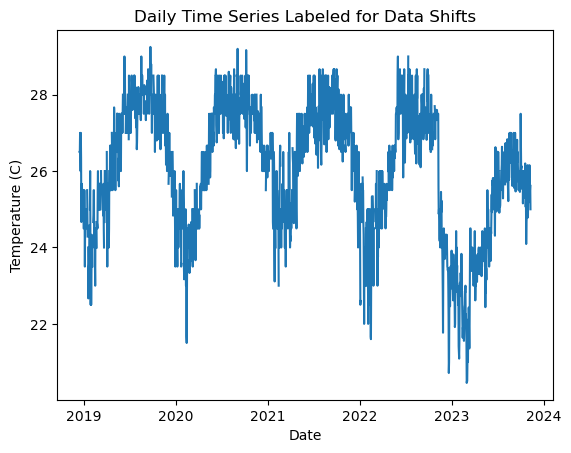

In [10]:
# Resample the time series to daily mean
temp_time_series_daily = temp_time_series.resample('D').mean()
data_shift_start_date, data_shift_end_date = \
    ds.get_longest_shift_segment_dates(temp_time_series_daily)
data_shift_period_length = (data_shift_end_date -
                            data_shift_start_date).days

# Get the number of shift dates
data_shift_mask = ds.detect_data_shifts(temp_time_series_daily)
# Get the shift dates
shift_dates = list(temp_time_series_daily[data_shift_mask].index)
if len(shift_dates) > 0:
    shift_found = True
else:
    shift_found = False

# Visualize the time shifts for the daily time series
print("Shift Found: ", shift_found)
edges = ([temp_time_series_daily.index[0]] + shift_dates +
         [temp_time_series_daily.index[-1]])
fig, ax = plt.subplots()
for (st, ed) in zip(edges[:-1], edges[1:]):
    ax.plot(temp_time_series_daily.loc[st:ed])
plt.title("Daily Time Series Labeled for Data Shifts")
plt.xlabel("Date")
plt.ylabel(f"Temperature ({temp_units})")
plt.show()

Finally, we filter the time series to only include the longest shift-free period. We then visualize the 
final time series post-QA filtering.

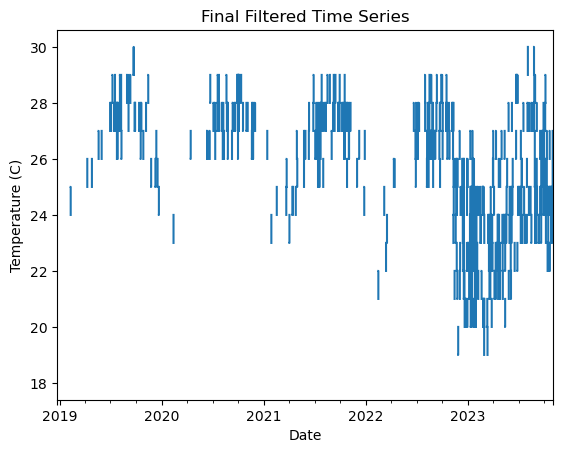

In [11]:
temp_time_series = temp_time_series[
    (temp_time_series.index >=
     data_shift_start_date.tz_convert(temp_time_series.index.tz)) &
    (temp_time_series.index <=
     data_shift_end_date.tz_convert(temp_time_series.index.tz))]

# Plot the final filtered time series.
temp_time_series.plot(title="Final Filtered Time Series")
plt.xlabel("Date")
plt.ylabel(f"Temperature ({temp_units})")
plt.show()

Generate a dictionary output for the QA assessment of this data stream, including the percent stale and erroneous data detected, any shift dates, and the detected temperature units for the data stream.

In [12]:
qa_check_dict = {"temperature_units": temp_units,
                 "pct_stale": pct_stale,
                 "pct_erroneous": pct_erroneous,
                 "pct_outlier": pct_outlier,
                 "data_shifts": shift_found,
                 "shift_dates": shift_dates}

print("QA Results:")
print(qa_check_dict)

QA Results:
{'temperature_units': 'C', 'pct_stale': 94.4, 'pct_erroneous': 0.0, 'pct_outlier': 0.0, 'data_shifts': False, 'shift_dates': []}


Total running time of the script:

## 3.2: Fleets QA Process - Irradiance

PV Fleets Irradiance QA Pipeline

The NREL PV Fleets Data Initiative uses PVAnalytics routines to assess the quality of systems’ PV data. In this example, the PV Fleets process for assessing the data quality of an irradiance data stream is shown. This example pipeline illustrates how several PVAnalytics functions can be used in sequence to assess the quality of an irradiance data stream.

First, we import irradiance data stream from a PV installation under the [2023 solar data prize data set](https://data.openei.org/s3_viewer?bucket=oedi-data-lake&limit=100&prefix=pvdaq%2F2023-solar-data-prize%2F). This data set is publicly available via the PVDAQ database in the DOE Open Energy Data Initiative (OEDI) (https://data.openei.org/submissions/4568), under system ID 2105. This data is timezone-localized.

In [13]:
# Get irridance column and turn it into a series
irradiance_time_series = main_time_series["irradiance_ghi_o_150230"].dropna()

data_freq = "15T"
irradiance_time_series = irradiance_time_series.asfreq(data_freq)

First, let’s visualize the original time series as reference.

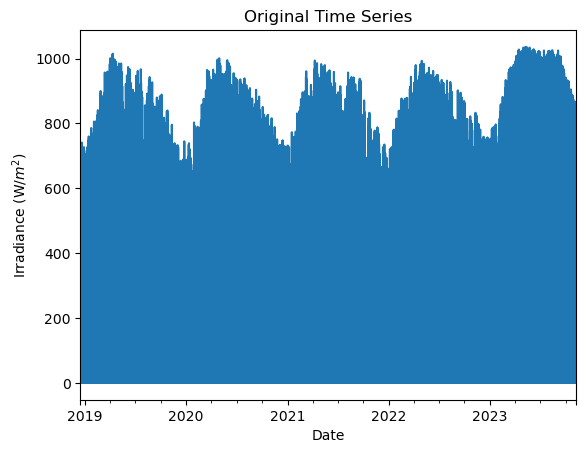

In [14]:
irradiance_time_series.plot(title="Original Time Series")
plt.xlabel("Date")
plt.ylabel("Irradiance " + f"(W/$m^2$)")
plt.show()

Now, let’s run basic data checks to identify stale and abnormal/outlier data in the time series. Basic data checks include the following steps:

1) Flatlined/stale data periods [(pvanalytics.quality.gaps.stale_values_round())](https://pvanalytics--202.org.readthedocs.build/en/202/generated/pvanalytics.quality.gaps.stale_values_round.html#pvanalytics.quality.gaps.stale_values_round)
2) Negative irradiance data
3) “Abnormal” data periods, which are defined as less than 10% of the daily time series mean OR greater than 1300
4) Outliers, which are defined as more than one 4 standard deviations away from the mean [(pvanalytics.quality.outliers.zscore())](https://pvanalytics--202.org.readthedocs.build/en/202/generated/pvanalytics.quality.outliers.zscore.html#pvanalytics.quality.outliers.zscore)

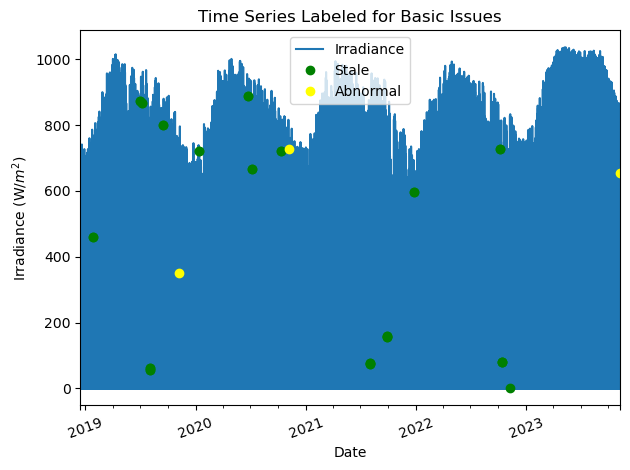

In [15]:
# REMOVE STALE DATA (that isn't during nighttime periods)
# Day/night mask
daytime_mask = power_or_irradiance(irradiance_time_series)
# Stale data mask
stale_data_mask = gaps.stale_values_round(irradiance_time_series,
                                          window=3,
                                          decimals=2)
stale_data_mask = stale_data_mask & daytime_mask

# REMOVE NEGATIVE DATA
negative_mask = (irradiance_time_series < 0)

# FIND ABNORMAL PERIODS
daily_min = irradiance_time_series.resample('D').min()
erroneous_mask = (daily_min > 50)
erroneous_mask = erroneous_mask.reindex(index=irradiance_time_series.index,
                                        method='ffill',
                                        fill_value=False)

# Remove values greater than or equal to 1300
out_of_bounds_mask = (irradiance_time_series >= 1300)

# FIND OUTLIERS (Z-SCORE FILTER)
zscore_outlier_mask = zscore(irradiance_time_series,
                             zmax=4,
                             nan_policy='omit')

# Get the percentage of data flagged for each issue, so it can later be logged
pct_stale = round((len(irradiance_time_series[
    stale_data_mask].dropna())/len(irradiance_time_series.dropna())*100), 1)
pct_negative = round((len(irradiance_time_series[
    negative_mask].dropna())/len(irradiance_time_series.dropna())*100), 1)
pct_erroneous = round((len(irradiance_time_series[
    erroneous_mask].dropna())/len(irradiance_time_series.dropna())*100), 1)
pct_outlier = round((len(irradiance_time_series[
    zscore_outlier_mask].dropna())/len(irradiance_time_series.dropna())*100), 1)

# Visualize all of the time series issues (stale, abnormal, outlier, etc)
irradiance_time_series.plot()
labels = ["Irradiance"]
if any(stale_data_mask):
    irradiance_time_series.loc[stale_data_mask].plot(ls='', marker='o', color="green")
    labels.append("Stale")
if any(negative_mask):
    irradiance_time_series.loc[negative_mask].plot(ls='', marker='o', color="orange")
    labels.append("Negative")
if any(erroneous_mask):
    irradiance_time_series.loc[erroneous_mask].plot(ls='', marker='o', color="yellow")
    labels.append("Abnormal")
if any(out_of_bounds_mask):
    irradiance_time_series.loc[out_of_bounds_mask].plot(ls='', marker='o', color="yellow")
    labels.append("Too High")
if any(zscore_outlier_mask):
    irradiance_time_series.loc[zscore_outlier_mask].plot(
        ls='', marker='o', color="purple")
    labels.append("Outlier")
plt.legend(labels=labels)
plt.title("Time Series Labeled for Basic Issues")
plt.xticks(rotation=20)
plt.xlabel("Date")
plt.ylabel("Irradiance " + f"(W/$m^2$)")
plt.tight_layout()
plt.show()

Now, let’s filter out any of the flagged data from the basic irradiance checks (stale or abnormal data). Then we can re-visualize the data post-filtering.

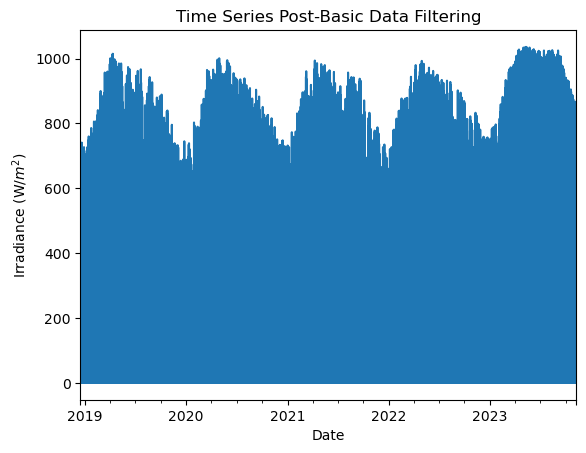

In [16]:
# Filter the time series, taking out all of the issues
issue_mask = ((~stale_data_mask) & (~negative_mask) & (~erroneous_mask) &
              (~out_of_bounds_mask) & (~zscore_outlier_mask))
irradiance_time_series = irradiance_time_series[issue_mask]

irradiance_time_series = irradiance_time_series.asfreq(data_freq)

# Visualize the time series post-filtering
irradiance_time_series.plot(title="Time Series Post-Basic Data Filtering")
plt.xlabel("Date")
plt.ylabel("Irradiance " + f"(W/$m^2$)")
plt.show()

We filter the time series based on its daily completeness score. This filtering scheme requires at least 25% of data to be present for each day to be included. We further require at least 10 consecutive days meeting this 25% threshold to be included.

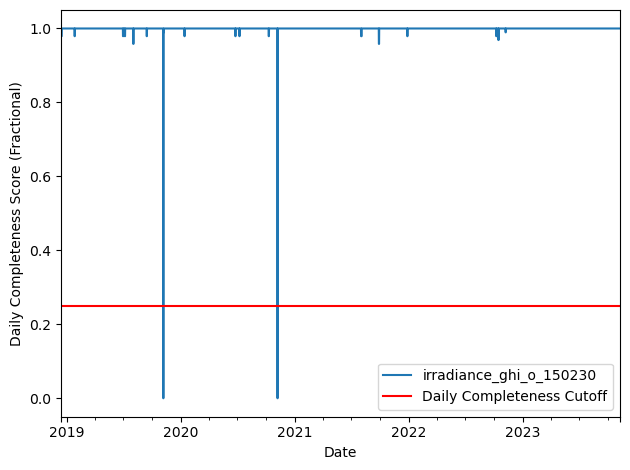

TypeError: Cannot compare tz-naive and tz-aware datetime-like objects

In [17]:
# Visualize daily data completeness
data_completeness_score = gaps.completeness_score(irradiance_time_series)

# Visualize data completeness score as a time series.
data_completeness_score.plot()
plt.xlabel("Date")
plt.ylabel("Daily Completeness Score (Fractional)")
plt.axhline(y=0.25, color='r', linestyle='-',
            label='Daily Completeness Cutoff')
plt.legend()
plt.tight_layout()
plt.show()

# Trim the series based on daily completeness score
trim_series = pvanalytics.quality.gaps.trim_incomplete(
    irradiance_time_series,
    minimum_completeness=.25,
    freq=data_freq)
first_valid_date, last_valid_date = \
    pvanalytics.quality.gaps.start_stop_dates(irradiance_time_series)
irradiance_time_series = irradiance_time_series[first_valid_date.tz_convert(irradiance_time_series.index.tz):
                          last_valid_date.tz_convert(irradiance_time_series.index.tz)]
irradiance_time_series = irradiance_time_series.asfreq(data_freq)


Next, we check the time series for any time shifts, which may be caused by time drift or by incorrect time zone assignment. To do this, we compare the modelled midday time for the particular system location to its measured midday time. We use [pvanalytics.quality.gaps.stale_values_round()](https://pvanalytics--202.org.readthedocs.build/en/202/generated/pvanalytics.quality.gaps.stale_values_round.html#pvanalytics.quality.gaps.stale_values_round) to determine the presence of time shifts in the series.

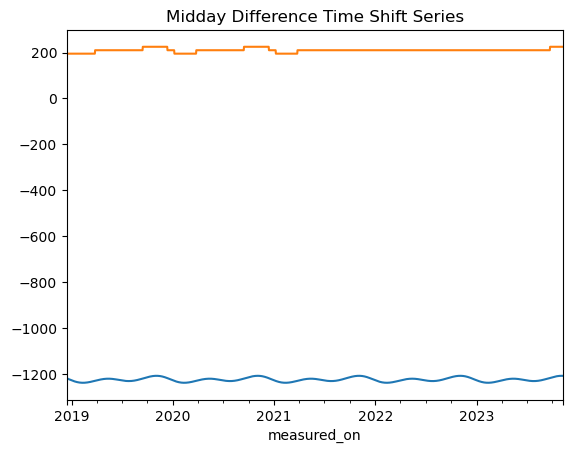

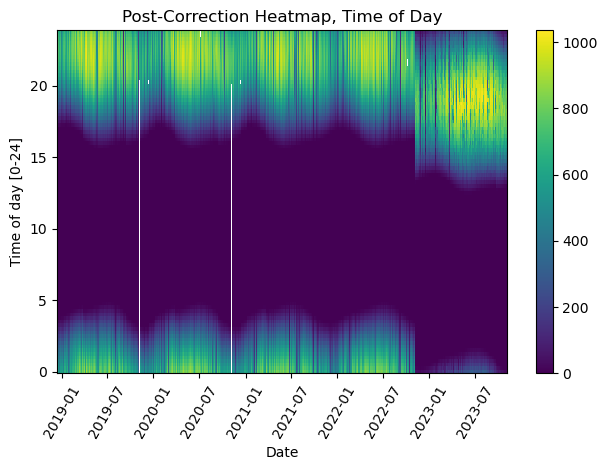

In [18]:
# Get the modeled sunrise and sunset time series based on the system's
# latitude-longitude coordinates
modeled_sunrise_sunset_df = pvlib.solarposition.sun_rise_set_transit_spa(
    irradiance_time_series.index, latitude, longitude)

# Calculate the midday point between sunrise and sunset for each day
# in the modeled irradiance series
modeled_midday_series = modeled_sunrise_sunset_df['sunrise'] + \
    (modeled_sunrise_sunset_df['sunset'] -
     modeled_sunrise_sunset_df['sunrise']) / 2

# Run day-night mask on the irradiance time series
daytime_mask = power_or_irradiance(irradiance_time_series,
                                   freq=data_freq,
                                   low_value_threshold=.005)

# Generate the sunrise, sunset, and halfway points for the data stream
sunrise_series = daytime.get_sunrise(daytime_mask)
sunset_series = daytime.get_sunset(daytime_mask)
midday_series = sunrise_series + ((sunset_series - sunrise_series)/2)

# Convert the midday and modeled midday series to daily values
midday_series_daily, modeled_midday_series_daily = (
    midday_series.resample('D').mean(),
    modeled_midday_series.resample('D').mean())

# Set midday value series as minutes since midnight, from midday datetime
# values
midday_series_daily = (midday_series_daily.dt.hour * 60 +
                       midday_series_daily.dt.minute +
                       midday_series_daily.dt.second / 60)
modeled_midday_series_daily = \
    (modeled_midday_series_daily.dt.hour * 60 +
     modeled_midday_series_daily.dt.minute +
     modeled_midday_series_daily.dt.second / 60)

# Estimate the time shifts by comparing the modelled midday point to the
# measured midday point.
is_shifted, time_shift_series = shifts_ruptures(midday_series_daily,
                                                modeled_midday_series_daily,
                                                period_min=15,
                                                shift_min=15,
                                                zscore_cutoff=1.5)

# Create a midday difference series between modeled and measured midday, to
# visualize time shifts. First, resample each time series to daily frequency,
# and compare the data stream's daily halfway point to the modeled halfway
# point
midday_diff_series = (midday_series.resample('D').mean() -
                      modeled_midday_series.resample('D').mean()
                      ).dt.total_seconds() / 60

# Generate boolean for detected time shifts
if any(time_shift_series != 0):
    time_shifts_detected = True
else:
    time_shifts_detected = False

# Build a list of time shifts for re-indexing. We choose to use dicts.
time_shift_series.index = pd.to_datetime(
    time_shift_series.index)
changepoints = (time_shift_series != time_shift_series.shift(1))
changepoints = changepoints[changepoints].index
changepoint_amts = pd.Series(time_shift_series.loc[changepoints])
time_shift_list = list()
for idx in range(len(changepoint_amts)):
    if changepoint_amts[idx] == 0:
        change_amt = 0
    else:
        change_amt = -1 * changepoint_amts[idx]
    if idx < (len(changepoint_amts) - 1):
        time_shift_list.append({"datetime_start":
                                str(changepoint_amts.index[idx]),
                                "datetime_end":
                                    str(changepoint_amts.index[idx + 1]),
                                "time_shift": change_amt})
    else:
        time_shift_list.append({"datetime_start":
                                str(changepoint_amts.index[idx]),
                                "datetime_end":
                                    str(time_shift_series.index.max()),
                                "time_shift": change_amt})

# Correct any time shifts in the time series
new_index = pd.Series(irradiance_time_series.index, index=irradiance_time_series.index)
for i in time_shift_list:
    new_index[(irradiance_time_series.index >= pd.to_datetime(i['datetime_start'])) &
              (irradiance_time_series.index < pd.to_datetime(i['datetime_end']))] = \
        irradiance_time_series.index + pd.Timedelta(minutes=i['time_shift'])
irradiance_time_series.index = new_index

# Remove duplicated indices and sort the time series (just in case)
irradiance_time_series = irradiance_time_series[~irradiance_time_series.index.duplicated(
    keep='first')].sort_index()

# Plot the difference between measured and modeled midday, as well as the
# CPD-estimated time shift series.
midday_diff_series.plot()
time_shift_series.plot()
plt.title("Midday Difference Time Shift Series")
plt.show()

# Plot the heatmap of the irradiance time series
plt.figure()
# Get time of day from the associated datetime column
time_of_day = pd.Series(irradiance_time_series.index.hour +
                        irradiance_time_series.index.minute/60,
                        index=irradiance_time_series.index)
# Pivot the dataframe
dataframe = pd.DataFrame(pd.concat([irradiance_time_series, time_of_day], axis=1))
dataframe.columns = ["values", 'time_of_day']
dataframe = dataframe.dropna()
dataframe_pivoted = dataframe.pivot_table(index='time_of_day',
                                          columns=dataframe.index.date,
                                          values="values")
plt.pcolormesh(dataframe_pivoted.columns,
               dataframe_pivoted.index,
               dataframe_pivoted,
               shading='auto')
plt.ylabel('Time of day [0-24]')
plt.xlabel('Date')
plt.xticks(rotation=60)
plt.title('Post-Correction Heatmap, Time of Day')
plt.colorbar()
plt.tight_layout()
plt.show()

Next, we check the time series for any abrupt data shifts. We take the longest continuous part of the time series that is free of data shifts. We use [pvanalytics.quality.data_shifts.detect_data_shifts()](https://pvanalytics--202.org.readthedocs.build/en/202/generated/pvanalytics.quality.data_shifts.detect_data_shifts.html#pvanalytics.quality.data_shifts.detect_data_shifts) to detect data shifts in the time series.

Shift Found: False


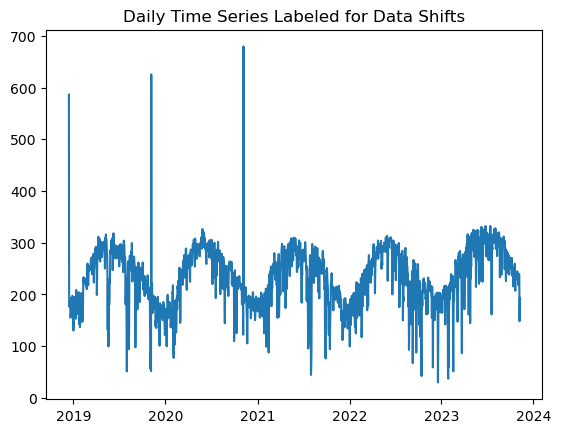

In [19]:
# Resample the time series to daily mean
irradiance_time_series_daily = irradiance_time_series.resample('D').mean()
data_shift_start_date, data_shift_end_date = \
    ds.get_longest_shift_segment_dates(irradiance_time_series_daily)
data_shift_period_length = (data_shift_end_date - data_shift_start_date).days

# Get the number of shift dates
data_shift_mask = ds.detect_data_shifts(irradiance_time_series_daily)
# Get the shift dates
shift_dates = list(irradiance_time_series_daily[data_shift_mask].index)
if len(shift_dates) > 0:
    shift_found = True
else:
    shift_found = False

# Visualize the time shifts for the daily time series
print("Shift Found:", shift_found)
edges = [irradiance_time_series_daily.index[0]] + \
    shift_dates + [irradiance_time_series_daily.index[-1]]
fig, ax = plt.subplots()
for (st, ed) in zip(edges[:-1], edges[1:]):
    ax.plot(irradiance_time_series_daily.loc[st:ed])
plt.title("Daily Time Series Labeled for Data Shifts")
plt.show()

We filter the time series to only include the longest shift-free period.

In [22]:
# Filter the time series to only include the longest shift-free period
irradiance_time_series = irradiance_time_series[
    (irradiance_time_series.index >= data_shift_start_date.tz_convert(
        irradiance_time_series.index.tz)) &
    (irradiance_time_series.index <= data_shift_end_date.tz_convert(
        irradiance_time_series.index.tz))]

irradiance_time_series = irradiance_time_series.asfreq(data_freq)

Display the final irradiance time series, post-QA filtering.

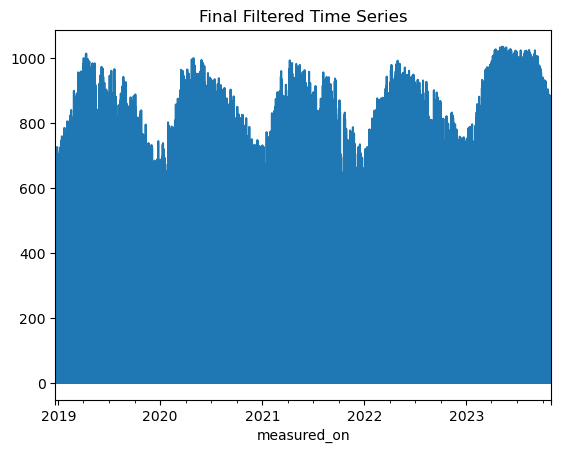

In [23]:
irradiance_time_series.plot(title="Final Filtered Time Series")
plt.show()
plt.close()

Generate a dictionary output for the QA assessment of this data stream, including the percent stale and erroneous data detected, any shift dates, and any detected time shifts.

In [24]:
qa_check_dict = {"original_time_zone_offset": irradiance_time_series.index.tz,
                 "pct_stale": pct_stale,
                 "pct_negative": pct_negative,
                 "pct_erroneous": pct_erroneous,
                 "pct_outlier": pct_outlier,
                 "time_shifts_detected": time_shifts_detected,
                 "time_shift_list": time_shift_list,
                 "data_shifts": shift_found,
                 "shift_dates": shift_dates}

print("QA Results:")
print(qa_check_dict)

QA Results:
{'original_time_zone_offset': <StaticTzInfo 'Etc/GMT-10'>, 'pct_stale': 0.0, 'pct_negative': 0.0, 'pct_erroneous': 0.0, 'pct_outlier': 0.0, 'time_shifts_detected': True, 'time_shift_list': [{'datetime_start': '2018-12-15 00:00:00+10:00', 'datetime_end': '2019-03-27 00:00:00+10:00', 'time_shift': -195.0}, {'datetime_start': '2019-03-27 00:00:00+10:00', 'datetime_end': '2019-09-15 00:00:00+10:00', 'time_shift': -210.0}, {'datetime_start': '2019-09-15 00:00:00+10:00', 'datetime_end': '2019-12-13 00:00:00+10:00', 'time_shift': -225.0}, {'datetime_start': '2019-12-13 00:00:00+10:00', 'datetime_end': '2020-01-07 00:00:00+10:00', 'time_shift': -210.0}, {'datetime_start': '2020-01-07 00:00:00+10:00', 'datetime_end': '2020-03-26 00:00:00+10:00', 'time_shift': -195.0}, {'datetime_start': '2020-03-26 00:00:00+10:00', 'datetime_end': '2020-09-14 00:00:00+10:00', 'time_shift': -210.0}, {'datetime_start': '2020-09-14 00:00:00+10:00', 'datetime_end': '2020-12-13 00:00:00+10:00', 'time_shi

Total running time of the script:

## 3.2: Fleets QA Process - Power

PV Fleets Power QA Pipeline

The NREL PV Fleets Data Initiative uses PVAnalytics routines to assess the quality of systems’ PV data. In this example, the PV Fleets process for assessing the data quality of an AC power data stream is shown. This example pipeline illustrates how several PVAnalytics functions can be used in sequence to assess the quality of a power or energy data stream.

First, we import an AC power data stream from a PV installation at under the [2023 solar data prize data set](https://data.openei.org/s3_viewer?bucket=oedi-data-lake&limit=100&prefix=pvdaq%2F2023-solar-data-prize%2F). This data set is publicly available via the PVDAQ database in the DOE Open Energy Data Initiative (OEDI) (https://data.openei.org/submissions/4568), under system ID 2105. This data is timezone-localized.


In [25]:
# Get power column and turn it into a series
power_time_series = main_time_series["meter_ac_output_(kwatts)_meter_150161"].dropna()

data_freq = '15T'
power_time_series = power_time_series.asfreq(data_freq)

First, let’s visualize the original time series as reference.

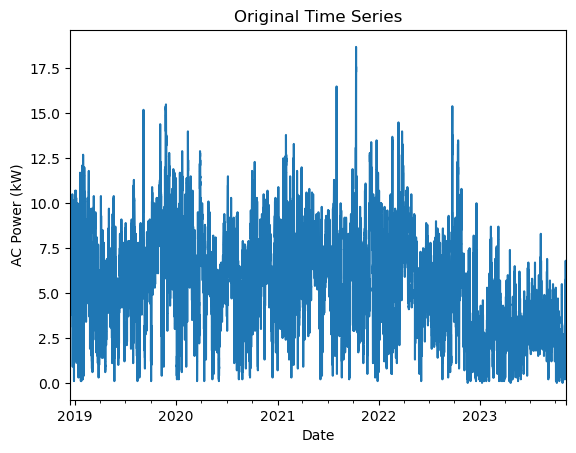

In [26]:
power_time_series.plot(title="Original Time Series")
plt.xlabel("Date")
plt.ylabel("AC Power (kW)")
plt.show()

Now, let’s run basic data checks to identify stale and abnormal/outlier data in the time series. Basic data checks include the following steps:

1) Flatlined/stale data periods [(pvanalytics.quality.gaps.stale_values_round())](https://pvanalytics--202.org.readthedocs.build/en/202/generated/pvanalytics.quality.gaps.stale_values_round.html#pvanalytics.quality.gaps.stale_values_round)
2) Negative data
3) “Abnormal” data periods, which are defined as less than 10% of the daily time series mean
4) Outliers, which are defined as more than one 4 standard deviations away from the mean [pvanalytics.quality.outliers.zscore()](https://pvanalytics--202.org.readthedocs.build/en/202/generated/pvanalytics.quality.outliers.zscore.html#pvanalytics.quality.outliers.zscore)

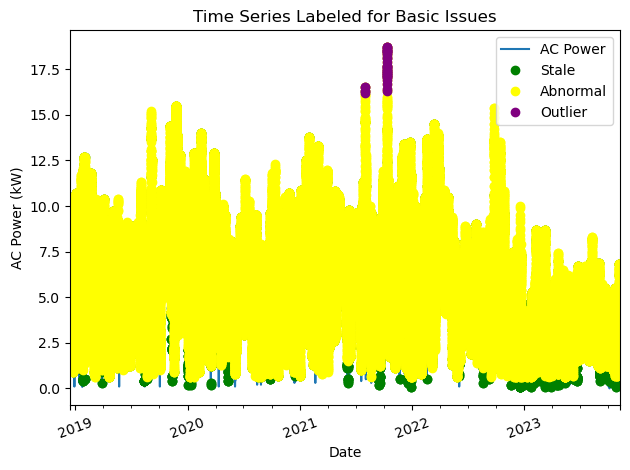

In [27]:
# REMOVE STALE DATA (that isn't during nighttime periods)
# Day/night mask
daytime_mask = power_or_irradiance(power_time_series)
# Stale data mask
stale_data_mask = gaps.stale_values_round(power_time_series,
                                          window=3,
                                          decimals=2)
stale_data_mask = stale_data_mask & daytime_mask

# REMOVE NEGATIVE DATA
negative_mask = (power_time_series < 0)

# FIND ABNORMAL PERIODS
daily_min = power_time_series.resample('D').min()
series_min = 0.1 * power_time_series.mean()
erroneous_mask = (daily_min >= series_min)
erroneous_mask = erroneous_mask.reindex(index=power_time_series.index,
                                        method='ffill',
                                        fill_value=False)

# FIND OUTLIERS (Z-SCORE FILTER)
zscore_outlier_mask = zscore(power_time_series, zmax=4,
                             nan_policy='omit')

# Get the percentage of data flagged for each issue, so it can later be logged
pct_stale = round((len(power_time_series[
    stale_data_mask].dropna())/len(power_time_series.dropna())*100), 1)
pct_negative = round((len(power_time_series[
    negative_mask].dropna())/len(power_time_series.dropna())*100), 1)
pct_erroneous = round((len(power_time_series[
    erroneous_mask].dropna())/len(power_time_series.dropna())*100), 1)
pct_outlier = round((len(power_time_series[
    zscore_outlier_mask].dropna())/len(power_time_series.dropna())*100), 1)

# Visualize all of the time series issues (stale, abnormal, outlier, etc)
power_time_series.plot()
labels = ["AC Power"]
if any(stale_data_mask):
    power_time_series.loc[stale_data_mask].plot(ls='', marker='o', color="green")
    labels.append("Stale")
if any(negative_mask):
    power_time_series.loc[negative_mask].plot(ls='', marker='o', color="orange")
    labels.append("Negative")
if any(erroneous_mask):
    power_time_series.loc[erroneous_mask].plot(ls='', marker='o', color="yellow")
    labels.append("Abnormal")
if any(zscore_outlier_mask):
    power_time_series.loc[zscore_outlier_mask].plot(
        ls='', marker='o', color="purple")
    labels.append("Outlier")
plt.legend(labels=labels)
plt.title("Time Series Labeled for Basic Issues")
plt.xticks(rotation=20)
plt.xlabel("Date")
plt.ylabel("AC Power (kW)")
plt.tight_layout()
plt.show()

Now, let’s filter out any of the flagged data from the basic power checks (stale or abnormal data). Then we can re-visualize the data post-filtering.

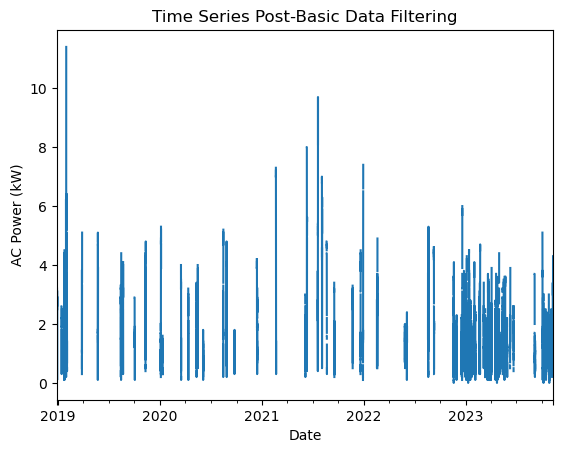

In [28]:
# Filter the time series, taking out all of the issues
issue_mask = ((~stale_data_mask) & (~negative_mask) &
          (~erroneous_mask) & (~zscore_outlier_mask))

power_time_series = power_time_series[issue_mask]
power_time_series = power_time_series.asfreq(data_freq)

# Visualize the time series post-filtering
power_time_series.plot(title="Time Series Post-Basic Data Filtering")
plt.xlabel("Date")
plt.ylabel("AC Power (kW)")
plt.show()

We filter the time series based on its daily completeness score. This filtering scheme requires at least 25% of data to be present for each day to be included. We further require at least 10 consecutive days meeting this 25% threshold to be included.

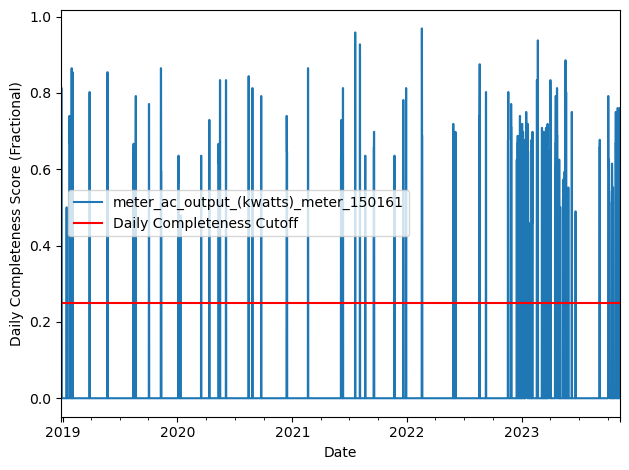

In [29]:
# Visualize daily data completeness
data_completeness_score = gaps.completeness_score(power_time_series)

# Visualize data completeness score as a time series.
data_completeness_score.plot()
plt.xlabel("Date")
plt.ylabel("Daily Completeness Score (Fractional)")
plt.axhline(y=0.25, color='r', linestyle='-',
            label='Daily Completeness Cutoff')
plt.legend()
plt.tight_layout()
plt.show()

# Trim the series based on daily completeness score
trim_series = pvanalytics.quality.gaps.trim_incomplete(
    power_time_series, minimum_completeness=.25, freq=data_freq)
first_valid_date, last_valid_date = \
    pvanalytics.quality.gaps.start_stop_dates(trim_series)
if first_valid_date is not None:
    power_time_series = power_time_series[first_valid_date.tz_localize(power_time_series.index.tz):
                              last_valid_date.tz_localize(power_time_series.index.tz)]
    power_time_series = power_time_series.asfreq(data_freq)

Next, we check the time series for any time shifts, which may be caused by time drift or by incorrect time zone assignment. To do this, we compare the modelled midday time for the particular system location to its measured midday time. We use [pvanalytics.quality.gaps.stale_values_round())](https://pvanalytics--202.org.readthedocs.build/en/202/generated/pvanalytics.quality.gaps.stale_values_round.html#pvanalytics.quality.gaps.stale_values_round) to determine the presence of time shifts in the series.

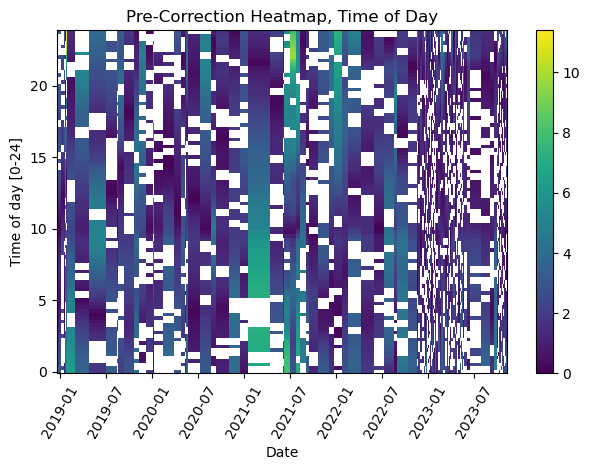

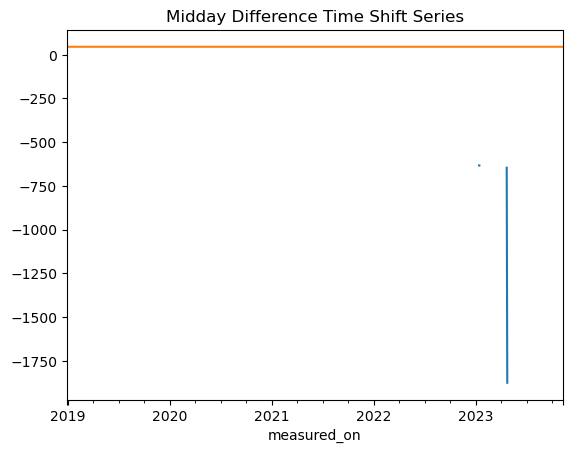

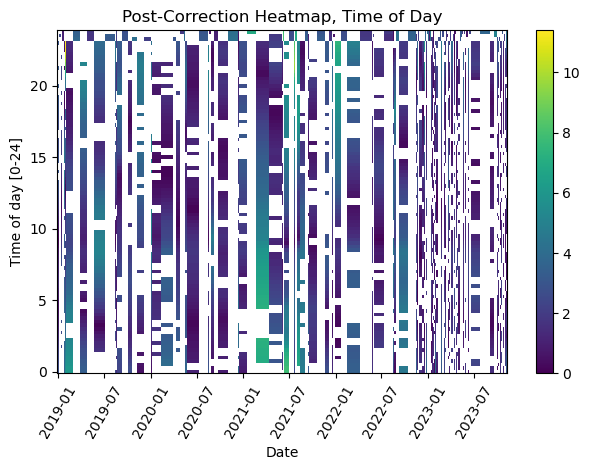

In [30]:
# Plot the heatmap of the AC power time series before time shift correction.
plt.figure()
# Get time of day from the associated datetime column
time_of_day = pd.Series(power_time_series.index.hour +
                        power_time_series.index.minute/60,
                        index=power_time_series.index)
# Pivot the dataframe
dataframe = pd.DataFrame(pd.concat([power_time_series, time_of_day], axis=1))
dataframe.columns = ["values", 'time_of_day']
dataframe = dataframe.dropna()
dataframe_pivoted = dataframe.pivot_table(index='time_of_day',
                                          columns=dataframe.index.date,
                                          values="values")
plt.pcolormesh(dataframe_pivoted.columns,
               dataframe_pivoted.index,
               dataframe_pivoted,
               shading='auto')
plt.ylabel('Time of day [0-24]')
plt.xlabel('Date')
plt.xticks(rotation=60)
plt.title('Pre-Correction Heatmap, Time of Day')
plt.colorbar()
plt.tight_layout()
plt.show()

# Get the modeled sunrise and sunset time series based on the system's
# latitude-longitude coordinates
modeled_sunrise_sunset_df = pvlib.solarposition.sun_rise_set_transit_spa(
     power_time_series.index, latitude, longitude)

# Calculate the midday point between sunrise and sunset for each day
# in the modeled irradiance series
modeled_midday_series = modeled_sunrise_sunset_df['sunrise'] + \
    (modeled_sunrise_sunset_df['sunset'] -
     modeled_sunrise_sunset_df['sunrise']) / 2

# Run day-night mask on the irradiance time series
daytime_mask = power_or_irradiance(power_time_series,
                                   freq=data_freq,
                                   low_value_threshold=.005)

# Generate the sunrise, sunset, and halfway points for the data stream
sunrise_series = daytime.get_sunrise(daytime_mask)
sunset_series = daytime.get_sunset(daytime_mask)
midday_series = sunrise_series + ((sunset_series - sunrise_series)/2)

# Convert the midday and modeled midday series to daily values
midday_series_daily, modeled_midday_series_daily = (
    midday_series.resample('D').mean(),
    modeled_midday_series.resample('D').mean())

# Set midday value series as minutes since midnight, from midday datetime
# values
midday_series_daily = (midday_series_daily.dt.hour * 60 +
                       midday_series_daily.dt.minute +
                       midday_series_daily.dt.second / 60)
modeled_midday_series_daily = \
    (modeled_midday_series_daily.dt.hour * 60 +
     modeled_midday_series_daily.dt.minute +
     modeled_midday_series_daily.dt.second / 60)

# Estimate the time shifts by comparing the modelled midday point to the
# measured midday point.
is_shifted, time_shift_series = shifts_ruptures(midday_series_daily,
                                                modeled_midday_series_daily,
                                                period_min=15,
                                                shift_min=15,
                                                zscore_cutoff=1.5)

# Create a midday difference series between modeled and measured midday, to
# visualize time shifts. First, resample each time series to daily frequency,
# and compare the data stream's daily halfway point to the modeled halfway
# point
midday_diff_series = (midday_series.resample('D').mean() -
                      modeled_midday_series.resample('D').mean()
                      ).dt.total_seconds() / 60

# Generate boolean for detected time shifts
if any(time_shift_series != 0):
    time_shifts_detected = True
else:
    time_shifts_detected = False

# Build a list of time shifts for re-indexing. We choose to use dicts.
time_shift_series.index = pd.to_datetime(
    time_shift_series.index)
changepoints = (time_shift_series != time_shift_series.shift(1))
changepoints = changepoints[changepoints].index
changepoint_amts = pd.Series(time_shift_series.loc[changepoints])
time_shift_list = list()
for idx in range(len(changepoint_amts)):
    if changepoint_amts[idx] == 0:
        change_amt = 0
    else:
        change_amt = -1 * changepoint_amts[idx]
    if idx < (len(changepoint_amts) - 1):
        time_shift_list.append({"datetime_start":
                                str(changepoint_amts.index[idx]),
                                "datetime_end":
                                    str(changepoint_amts.index[idx + 1]),
                                "time_shift": change_amt})
    else:
        time_shift_list.append({"datetime_start":
                                str(changepoint_amts.index[idx]),
                                "datetime_end":
                                    str(time_shift_series.index.max()),
                                "time_shift": change_amt})

# Correct any time shifts in the time series
new_index = pd.Series(power_time_series.index, index=power_time_series.index)
for i in time_shift_list:
    new_index[(power_time_series.index >= pd.to_datetime(i['datetime_start'])) &
              (power_time_series.index < pd.to_datetime(i['datetime_end']))] = \
        power_time_series.index + pd.Timedelta(minutes=i['time_shift'])
power_time_series.index = new_index

# Remove duplicated indices and sort the time series (just in case)
power_time_series = power_time_series[~power_time_series.index.duplicated(
    keep='first')].sort_index()

# Plot the difference between measured and modeled midday, as well as the
# CPD-estimated time shift series.
plt.figure()
midday_diff_series.plot()
time_shift_series.plot()
plt.title("Midday Difference Time Shift Series")
plt.show()

# Plot the heatmap of the irradiance time series
plt.figure()
# Get time of day from the associated datetime column
time_of_day = pd.Series(power_time_series.index.hour +
                        power_time_series.index.minute/60,
                        index=power_time_series.index)
# Pivot the dataframe
dataframe = pd.DataFrame(pd.concat([power_time_series, time_of_day], axis=1))
dataframe.columns = ["values", 'time_of_day']
dataframe = dataframe.dropna()
dataframe_pivoted = dataframe.pivot_table(index='time_of_day',
                                          columns=dataframe.index.date,
                                          values="values")
plt.pcolormesh(dataframe_pivoted.columns,
               dataframe_pivoted.index,
               dataframe_pivoted,
               shading='auto')
plt.ylabel('Time of day [0-24]')
plt.xlabel('Date')
plt.xticks(rotation=60)
plt.title('Post-Correction Heatmap, Time of Day')
plt.colorbar()
plt.tight_layout()
plt.show()

Next, we check the time series for any abrupt data shifts. We take the longest continuous part of the time series that is free of data shifts. We use [pvanalytics.quality.data_shifts.detect_data_shifts()](https://pvanalytics--202.org.readthedocs.build/en/202/generated/pvanalytics.quality.data_shifts.detect_data_shifts.html#pvanalytics.quality.data_shifts.detect_data_shifts) to detect data shifts in the time series.

Shift Found:  False


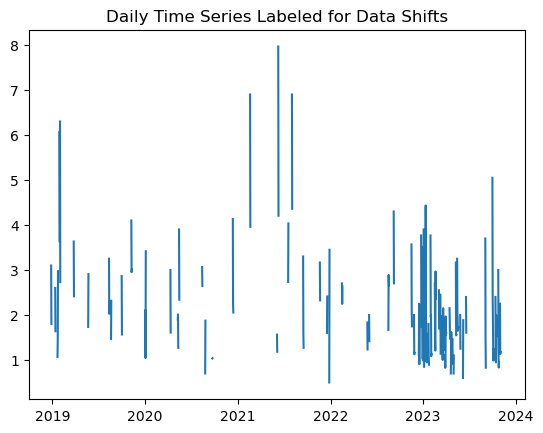

In [31]:
# Resample the time series to daily mean
power_time_series_daily = power_time_series.resample('D').mean()
data_shift_start_date, data_shift_end_date = \
    ds.get_longest_shift_segment_dates(power_time_series_daily)
data_shift_period_length = (data_shift_end_date -
                            data_shift_start_date).days

# Get the number of shift dates
data_shift_mask = ds.detect_data_shifts(power_time_series_daily)
# Get the shift dates
shift_dates = list(power_time_series_daily[data_shift_mask].index)
if len(shift_dates) > 0:
    shift_found = True
else:
    shift_found = False

# Visualize the time shifts for the daily time series
print("Shift Found: ", shift_found)
edges = ([power_time_series_daily.index[0]] + shift_dates +
         [power_time_series_daily.index[-1]])
fig, ax = plt.subplots()
for (st, ed) in zip(edges[:-1], edges[1:]):
    ax.plot(power_time_series_daily.loc[st:ed])
plt.title("Daily Time Series Labeled for Data Shifts")
plt.show()

We filter the time series to only include the longest shift-free period. We then visualize the final time series post-QA filtering.

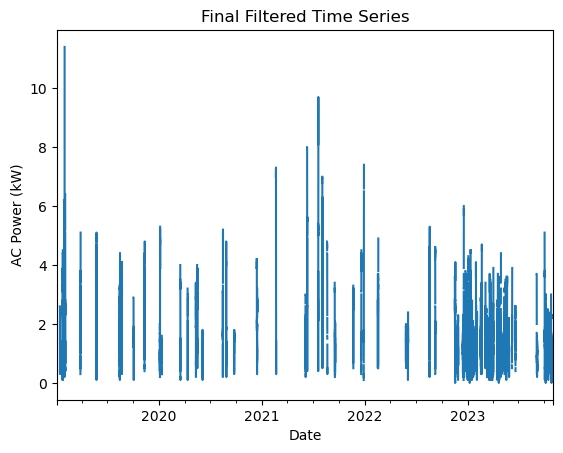

In [32]:
power_time_series = power_time_series[
    (power_time_series.index >=
     data_shift_start_date.tz_convert(power_time_series.index.tz)) &
    (power_time_series.index <=
     data_shift_end_date.tz_convert(power_time_series.index.tz))]

power_time_series = power_time_series.asfreq(data_freq)

# Plot the final filtered time series.
power_time_series.plot(title="Final Filtered Time Series")
plt.xlabel("Date")
plt.ylabel("AC Power (kW)")
plt.show()

Use logic-based and ML-based clipping functions to identify clipped periods in the time series data, and plot the filtered data.

In [33]:
# REMOVE CLIPPING PERIODS
clipping_mask = geometric(ac_power=power_time_series,
                          freq=data_freq)

# Get the pct clipping
clipping_mask.dropna(inplace=True)
pct_clipping = round(100*(len(clipping_mask[
    clipping_mask])/len(clipping_mask)), 4)
if pct_clipping >= 0.5:
    clipping = True
    clip_pwr = power_time_series[clipping_mask].median()
else:
    clipping = False
    clip_pwr = None

if clipping:
    # Plot the time series with clipping labeled
    power_time_series.plot()
    power_time_series.loc[clipping_mask].plot(ls='', marker='o')
    plt.legend(labels=["AC Power", "Clipping"],
               title="Clipped")
    plt.title("Time Series Labeled for Clipping")
    plt.xticks(rotation=20)
    plt.xlabel("Date")
    plt.ylabel("AC Power")
    plt.tight_layout()
    plt.show()
    plt.close()
else:
    print("No clipping detected!!!")

No clipping detected!!!


Estimate the azimuth and tilt of the system, based on the power series data. 

First, import the PSM3 data. This data is pulled via the following function in
[PVLib: :py:func: pvlib.iotools.get_psm3](https://pvlib-python.readthedocs.io/en/v0.9.0/generated/pvlib.iotools.get_psm3.html).

In [34]:
from pvlib.iotools import get_psm3
api_key = "OGvgxMGOYzbr5KcNtXbFl5Bp5lQazns8HZ8mvY87"
email = "qnguyen@nrel.gov"
attributes = ["ghi", "dhi", "dni"]
psm3_tuple = get_psm3(latitude, longitude, api_key = api_key, email = email, attributes = attributes)
psm3 = pd.DataFrame(psm3_tuple[0])
#print(psm3.iloc[0])
#print(psm3.iloc[-1])
#print(power_time_series)


Year      2017.0
Month        1.0
Day          1.0
Hour         0.0
Minute      30.0
GHI          0.0
DHI          0.0
DNI          0.0
Name: 2017-01-01 00:30:00-10:00, dtype: float64
Year      2017.0
Month       12.0
Day         31.0
Hour        23.0
Minute      30.0
GHI          0.0
DHI          0.0
DNI          0.0
Name: 2017-12-31 23:30:00-10:00, dtype: float64
measured_on
2019-01-03 00:00:00+10:00    NaN
2019-01-03 00:15:00+10:00    NaN
2019-01-03 00:30:00+10:00    NaN
2019-01-03 00:45:00+10:00    NaN
2019-01-03 01:00:00+10:00    NaN
                            ... 
2023-10-31 23:00:00+10:00    NaN
2023-10-31 23:15:00+10:00    2.2
2023-10-31 23:30:00+10:00    2.3
2023-10-31 23:45:00+10:00    NaN
2023-11-01 00:00:00+10:00    NaN
Freq: 15T, Name: meter_ac_output_(kwatts)_meter_150161, Length: 169249, dtype: float64


C:\Users\QNGUYEN\AppData\Local\anaconda3\Lib\site-packages\pvlib\iotools\psm3.py:360: pvlibDeprecationWarning: PSM3 variable names will be renamed to pvlib conventions by default starting in pvlib 0.11.0. Specify map_variables=True to enable that behavior now, or specify map_variables=False to hide this warning.
  warnings.warn(


In [98]:
psm3 = psm3.reindex(pd.date_range(psm3.index[0],
                                  psm3.index[-1],
                                  freq=data_freq)).interpolate()
psm3.index = psm3.index.tz_convert(power_time_series.index.tz)
#psm3 = psm3.reindex(power_time_series.index)
is_clear = (psm3.ghi_clear == psm3.ghi)
is_daytime = (psm3.ghi > 0)

# Trim based on clearsky and daytime values
time_series_clearsky = power_time_series.reindex(is_daytime.index)[
    (is_clear) & (is_daytime)].dropna()

# Get final PSM3 data
psm3_clearsky = psm3.loc[time_series_clearsky.index]
solpos_clearsky = pvlib.solarposition.get_solarposition(
    time_series_clearsky.index, latitude, longitude)

# Estimate the azimuth and tilt using PVWatts-based method
predicted_tilt, predicted_azimuth, r2 = infer_orientation_fit_pvwatts(
    time_series_clearsky,
    psm3_clearsky.ghi_clear,
    psm3_clearsky.dhi_clear,
    psm3_clearsky.dni_clear,
    solpos_clearsky.zenith,
    solpos_clearsky.azimuth,
    temperature=psm3_clearsky.temp_air,
    azimuth_min=90,
    azimuth_max=275)

print("Predicted azimuth: " + str(predicted_azimuth))
print("Predicted tilt: " + str(predicted_tilt))

AttributeError: 'DataFrame' object has no attribute 'ghi_clear'

Look at the daily power profile for summer and winter months, and identify if the data stream is associated with a fixed-tilt or single-axis tracking system.

In [ ]:
# CHECK MOUNTING CONFIGURATION
daytime_mask = power_or_irradiance(power_time_series)
predicted_mounting_config = is_tracking_envelope(power_time_series,
                                                 daytime_mask,
                                                 clipping_mask)

print("Predicted Mounting configuration:")
print(predicted_mounting_config.name)

Generate a dictionary output for the QA assessment of this data stream, including the percent stale and erroneous data detected, any shift dates, time shift dates, clipping information, and estimated mounting configuration.

In [ ]:
qa_check_dict = {"original_time_zone_offset": power_time_series.index.tz,
                 "pct_stale": pct_stale,
                 "pct_negative": pct_negative,
                 "pct_erroneous": pct_erroneous,
                 "pct_outlier": pct_outlier,
                 "time_shifts_detected": time_shifts_detected,
                 "time_shift_list": time_shift_list,
                 "data_shifts": shift_found,
                 "shift_dates": shift_dates,
                 "clipping": clipping,
                 "clipping_threshold": clip_pwr,
                 "pct_clipping": pct_clipping,
                 "mounting_config": predicted_mounting_config.name,
                 "predicted_azimuth": predicted_azimuth,
                 "predicted_tilt": predicted_tilt}

print("QA Results:")
print(qa_check_dict)

Total running time of the script:

# 4. Do PVAnalytics Clear-Sky Detection

Identifying periods of clear-sky conditions using measured irradiance.


Identifying and filtering for clear-sky conditions is a useful way to
reduce noise when analyzing measured data.  This example shows how to
use :py:func:`pvanalytics.features.clearsky.reno` to identify clear-sky
conditions using measured GHI data.  For this example we'll use
GHI measurements downloaded



In [ ]:
import pvanalytics
from pvanalytics.features.clearsky import reno
import pvlib
import matplotlib.pyplot as plt
import pandas as pd
import pathlib

First, read in the GHI measurements.  For this example we'll use an example
file included in pvanalytics covering a single day, but the same process
applies to data of any length.



In [ ]:
pvanalytics_dir = pathlib.Path(pvanalytics.__file__).parent
ghi_file = pvanalytics_dir / 'data' / 'midc_bms_ghi_20220120.csv'
data = pd.read_csv(ghi_file, index_col=0, parse_dates=True)

# or you can fetch the data straight from the source using pvlib:
# date = pd.to_datetime('2022-01-20')
# data = pvlib.iotools.read_midc_raw_data_from_nrel('BMS', date, date)

measured_ghi = data['Global CMP22 (vent/cor) [W/m^2]']

Now model clear-sky irradiance for the location and times of the
measured data:



In [ ]:
location = pvlib.location.Location(39.742, -105.18)
clearsky = location.get_clearsky(data.index)
clearsky_ghi = clearsky['ghi']

Finally, use :py:func:`pvanalytics.features.clearsky.reno` to identify
measurements during clear-sky conditions:



In [ ]:
is_clearsky = reno(measured_ghi, clearsky_ghi)

# clear-sky times indicated in black
measured_ghi.plot()
measured_ghi[is_clearsky].plot(ls='', marker='o', ms=2, c='k')
plt.ylabel('Global Horizontal Irradiance [W/m2]')
plt.show()